# SysArmy Surveys: Análisis por género de los resultados de todas las encuestas

Datos actualizados al 1er período de 2018

NOTA: Los primeros dos datasets no contienen información sobre género.

NOTA2: Los sueldos indicados son llevados a bruto, es decir, algunos encuestados optaron por informar sueldos netos,  estos valores netos fueron llevados a bruto mediante un cálculo simple pero a la vez impreciso.  Es importante aclarar que la imprecisión de la conversión tiende a la baja del salario, ya que no se tuvieron en cuenta descuentos por ganancias u otros beneficios.

### Datasets de sueldos

| Period  | Path             | URL                                                                                                         |
|---------|------------------|-------------------------------------------------------------------------------------------------------------|
| ~~2014.02~~ | data/2014.02.csv | https://drive.google.com/open?id=0B7UapTwn9AahWkdEWnltRjUwVjQ                                               |
| ~~2015.01~~ | data/2015.01.csv | https://drive.google.com/open?id=0B7UapTwn9AahSHl1aGNfTlNrYWc                                               |
| 2016.01 | data/2016.01.csv | https://drive.google.com/open?id=0B7UapTwn9AahLTJmSE5zOUQ0aGc                                               |
| 2016.02 | data/2016.02/    | https://drive.google.com/open?id=0B7UapTwn9AahUGtySFBjdHBCcWs                                               |
| 2017.01 | data/2017.01/    | https://docs.google.com/spreadsheets/d/1diZG7ruHJ4OgO2-tbnO-ZnhjxjOnYjMVSxl7I-4LT54/edit#gid=1424918437     |
| 2017.02 | data/2017.02/    | https://docs.google.com/spreadsheets/d/1f1CAmzbVtoL66IwXJWEf0Mn-QbMNGZIoCQ_b1HB-91E                         |
| 2018.01 | data/2018.01/    | https://docs.google.com/spreadsheets/d/1OcOGeYEsI-iIO_QNfl_8avUK2ifg9wRFUly-f-c1CJM/edit#gid=2144425141 |



In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import cm
from functools import reduce
from IPython.display import display, Markdown as md

def getPeriodDF(period, publish_date, csv_path, columns_src, columns_dst, transforms = []):
    # given a csv_path, extract src columns into dst columns by applying a transform function for a certain period name
    df_src = pd.read_csv(csv_path)
    df_dst = pd.DataFrame(columns=['period', 'publish_date']+columns_dst)
    df_dst[columns_dst] = df_src[columns_src]
    df_dst['period'] = period
    df_dst['publish_date'] = pd.to_datetime(publish_date)
    # apply custom transformations
    for transform in transforms:
        df_src, df_dst = transform(df_src, df_dst)
    return df_dst

def transformNormalize(df_src, df_dst):
    # cast to float the salary column, some datasets gets wrongly parsed due to crappy user input
    df_dst['salary'] = df_dst['salary'].astype(float)
    df_dst['age'] = df_dst['age'].astype(str)
    # normalize stack column
    re_separator = ' *, *| *; *| *\. *| *\| *| *\/ *| *- *'
    re_garbage = '"""|\*|nan|='
    df_dst['stack'] = df_dst['stack'].apply(lambda s: re.split(re_separator, re.sub(re_garbage, '', str(s)).strip().lower()))
    # munge the dataset, removing entries that we consider not realistic for our analysis
    munging_mask = (df_dst.salary > 5000) & (df_dst.salary < 300000)
    df_src = df_src.loc[munging_mask]
    df_dst = df_dst.loc[munging_mask]
    return df_src, df_dst

def transformNet2Brute(df_src, df_dst):
    # filter wether net or brute income
    mask = np.array(df_src['Bruto o neto?'].str.contains('Neto'), dtype = bool)
    net_factor = np.array([1.0] * len(df_dst));
    # scales up net salary into brute, given Argentina's social security contributions
    net_factor[ mask ] = 1/0.83
    df_dst['salary'] = net_factor * df_dst['salary']
    return df_src, df_dst

def transformNet2Brute201702(df_src, df_dst):
    # filter wether net or brute income
    mask = np.array(df_src['¿Porcentaje, bruto o neto?'].str.contains('Neto'), dtype = bool)
    net_factor = np.array([1.0] * len(df_dst));
    # scales up net salary into brute, given Argentina's social security contributions
    net_factor[ mask ] = 1/0.83
    df_dst['salary'] = net_factor * df_dst['salary']
    return df_src, df_dst

src_common_cols = [
    'Tengo',
    'Años de experiencia',
    'Años en el puesto actual',
    'Trabajo de',
    'Tecnologías que utilizás']

dst_cols = [
    'salary',
    'location',
    'gender',
    'increase',
    'happiness',
    'age',
    'yoe',
    'yip',
    'role',
    'stack']

df3 = getPeriodDF('2016.01', '2016-02-01', '../../data/2016.01.csv', 
                  ['Salario mensual (AR$)', 'Trabajo en', 'Soy', 'De qué % fue el ajuste anual?', 'Qué tan conforme estás con tu sueldo?'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute])

df4 = getPeriodDF('2016.02', '2016-08-01', '../../data/2016.02/argentina.csv', 
                  ['Salario mensual (en tu moneda local)', 'Argentina', 'Soy', 'De qué % fue el ajuste?', 'Qué tan conforme estás con tu sueldo?'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute])

df5 = getPeriodDF('2017.01', '2017-02-01', '../../data/2017.01/argentina.csv', 
                  ['Salario mensual (en tu moneda local)', 'Argentina', 'Soy', 'De qué % fue el ajuste?', 'Qué tan conforme estás con tu sueldo?'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute])

df6 = getPeriodDF('2017.02', '2017-09-01', '../../data/2017.02/argentina.csv', 
                  ['Salario mensual (en tu moneda local)', 'Argentina', 'Me identifico', '¿De qué % fue el ajuste?', '¿Qué tan conforme estás con tu sueldo?'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute201702])

df7 = getPeriodDF('2018.01', '2018-03-01', '../../data/2018.01/argentina.csv', 
                  ['Salario mensual (en tu moneda local)', 'Argentina', 'Me identifico', '¿De qué % fue el ajuste?', '¿Qué tan conforme estás con tu sueldo?'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute201702])

# compute the union of all the datasets as a signe pandas dataframe
df = pd.concat([df3, df4, df5, df6, df7])

# extract the list of periods
periods = df.period.unique()

# extract the list of genders
genders = df.gender.unique()

# extract the list of yoes
yoes = df.yoe.unique()

display(md('## Géneros censandos en los datasets'))
[display(md('- %s (%d total)' % (g, len(df.query('gender == "%s"' % g))))) for g in genders]

## Géneros censandos en los datasets

- Hombre (20492 total)

- Mujer (1977 total)

- Otros (33 total)

[None, None, None]

In [2]:
# define arbitrary ranges for seniority
yoes_jr = ['1 - 2', 'Menos de un año', '1', '2', '3']
yoes_ssr = ['3 - 5', '3', '4', '5', '6']
yoes_sr = ['5 - 7', '8 - 10', '5', '6', '7', '8', '9', '10', '10+']

yoes_ranges = [yoes_jr, yoes_ssr, yoes_sr]
yoes_ranges_names = ['Juniors', 'Semi-Seniors', 'Seniors']

display(md("""
## Años de experiencia

El seniority fue simplificado en tres niveles, de los cuales se seleccionaron arbitrariamente los rangos
que conforman estos niveles.  Para evitar discrepancias, se sobrelaparon rangos en los diferentes niveles.
Por ejemplo, un desarrollador con 3 años de experiencia puede considerarse Junior ó Semi-Senior a la vez, eso
dependerá de cada caso.

### Sobre la categoría "Otros"

Al parecer, solo se registra el grupo "Otros" en el último dataset, donde se lo habría incluído.  Por la 
cantidad baja de resultados, y la ausencia de dimensión tiempo en los datasets, resulta imposible visualilzar dichos
resultados.

A continuación se detalla las cantidades por segmento y período de la muestra.
"""))

for i, gender in enumerate(genders):
    display(md('### %s' % gender))
    for j, yoes_range in enumerate(yoes_ranges):
        display(md('#### %s' % yoes_ranges_names[j]))
        [display(md('- %s año(s) (%d total)' % (y, len(df.query('gender == @gender & yoe in @y'))))) for y in yoes_range]


## Años de experiencia

El seniority fue simplificado en tres niveles, de los cuales se seleccionaron arbitrariamente los rangos
que conforman estos niveles.  Para evitar discrepancias, se sobrelaparon rangos en los diferentes niveles.
Por ejemplo, un desarrollador con 3 años de experiencia puede considerarse Junior ó Semi-Senior a la vez, eso
dependerá de cada caso.

### Sobre la categoría "Otros"

Al parecer, solo se registra el grupo "Otros" en el último dataset, donde se lo habría incluído.  Por la 
cantidad baja de resultados, y la ausencia de dimensión tiempo en los datasets, resulta imposible visualilzar dichos
resultados.

A continuación se detalla las cantidades por segmento y período de la muestra.


### Hombre

#### Juniors

- 1 - 2 año(s) (1288 total)

- Menos de un año año(s) (962 total)

- 1 año(s) (505 total)

- 2 año(s) (721 total)

- 3 año(s) (814 total)

#### Semi-Seniors

- 3 - 5 año(s) (2203 total)

- 3 año(s) (814 total)

- 4 año(s) (677 total)

- 5 año(s) (958 total)

- 6 año(s) (720 total)

#### Seniors

- 5 - 7 año(s) (1718 total)

- 8 - 10 año(s) (1602 total)

- 5 año(s) (958 total)

- 6 año(s) (720 total)

- 7 año(s) (662 total)

- 8 año(s) (665 total)

- 9 año(s) (626 total)

- 10 año(s) (0 total)

- 10+ año(s) (6371 total)

### Mujer

#### Juniors

- 1 - 2 año(s) (115 total)

- Menos de un año año(s) (131 total)

- 1 año(s) (67 total)

- 2 año(s) (98 total)

- 3 año(s) (104 total)

#### Semi-Seniors

- 3 - 5 año(s) (171 total)

- 3 año(s) (104 total)

- 4 año(s) (99 total)

- 5 año(s) (127 total)

- 6 año(s) (90 total)

#### Seniors

- 5 - 7 año(s) (94 total)

- 8 - 10 año(s) (101 total)

- 5 año(s) (127 total)

- 6 año(s) (90 total)

- 7 año(s) (90 total)

- 8 año(s) (75 total)

- 9 año(s) (87 total)

- 10 año(s) (0 total)

- 10+ año(s) (528 total)

### Otros

#### Juniors

- 1 - 2 año(s) (0 total)

- Menos de un año año(s) (3 total)

- 1 año(s) (2 total)

- 2 año(s) (3 total)

- 3 año(s) (5 total)

#### Semi-Seniors

- 3 - 5 año(s) (0 total)

- 3 año(s) (5 total)

- 4 año(s) (2 total)

- 5 año(s) (0 total)

- 6 año(s) (3 total)

#### Seniors

- 5 - 7 año(s) (0 total)

- 8 - 10 año(s) (0 total)

- 5 año(s) (0 total)

- 6 año(s) (3 total)

- 7 año(s) (2 total)

- 8 año(s) (1 total)

- 9 año(s) (1 total)

- 10 año(s) (0 total)

- 10+ año(s) (11 total)

## Participación en las encuestas por género

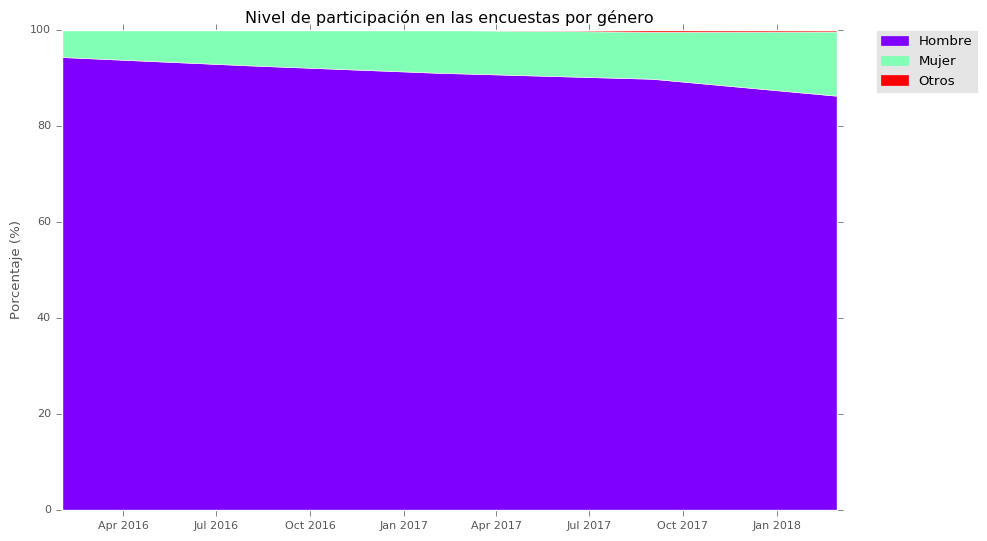

In [3]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use(['classic', 'ggplot'])
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 8})

genders_colors = cm.rainbow(np.linspace(0, 1, len(genders)))
publish_dates = np.unique(df['publish_date'])

y = []
for i, gender in enumerate(genders):
    gender_y = []
    for j, date in enumerate(publish_dates):
        count = df.query('gender == @gender & publish_date == @date').count()[0]
        gender_y.append(count)
    y.append(gender_y)

# define data points for stackplot
x = publish_dates
y = np.row_stack(y)
percent = np.divide(y, y.sum(axis=0).astype(float)*0.01)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.stackplot(x, percent, colors=genders_colors)
ax.set_title('Nivel de participación en las encuestas por género')
ax.set_ylabel('Porcentaje (%)')

display(md('## Participación en las encuestas por género'))

# creating the legend manually
plt.legend([mpatches.Patch(color=genders_colors[i]) for i, gender in enumerate(genders)],
           genders, 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

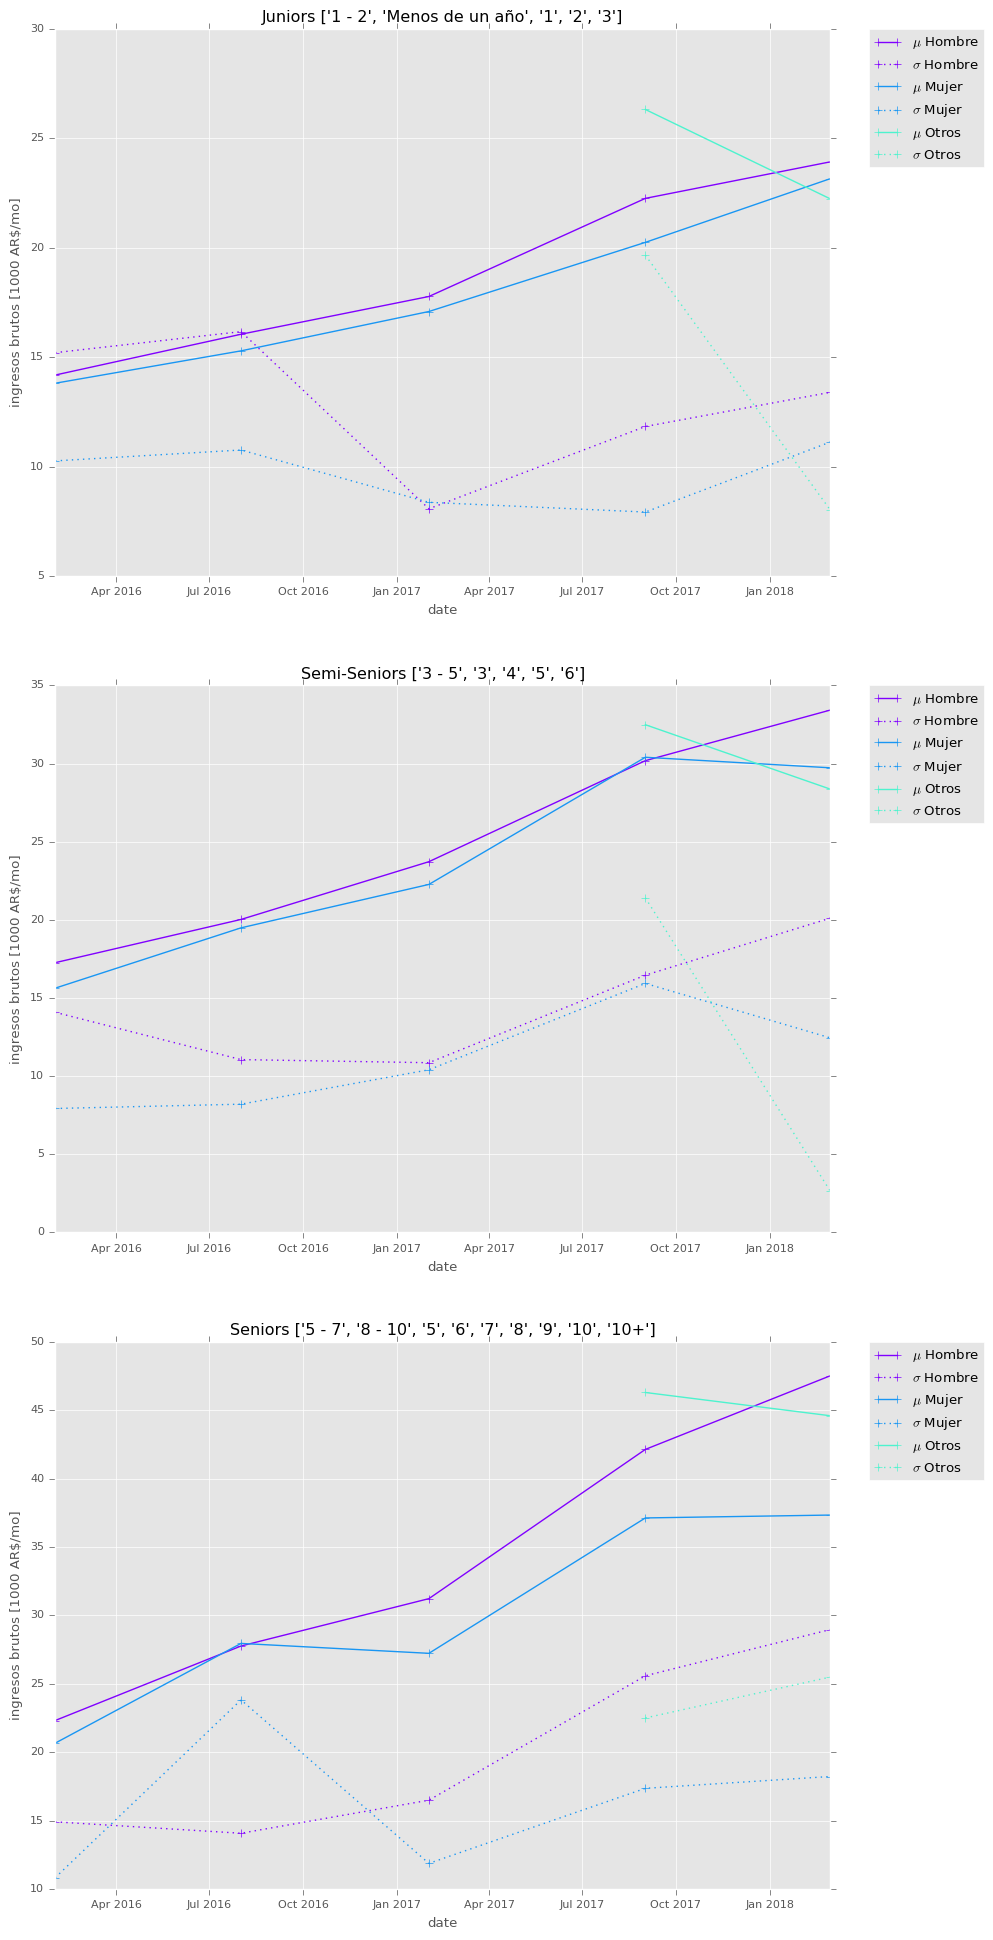

In [4]:
%matplotlib inline

def getPlotSalarySeries(currencySeries):
    s = currencySeries.apply(lambda x: float('{0:.2f}'.format(round(x/1000, 1))))
    mu, sigma = np.mean(s), np.std(s)
    median = np.median(s)
    t = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
    d = sigma**2/mu
    return mu, sigma, t, d, median, s

plt.rcParams.update({'figure.figsize': (10.0, 24.0), 'font.size': 8})
yoes_colors = cm.rainbow(np.linspace(0, 1, 2*len(yoes_ranges)))

dfnd = []

fig, ax = plt.subplots(len(yoes_ranges), 1)
for i, yoe_range in enumerate(yoes_ranges):
    for j, gender in enumerate(genders):
        mus, sigmas, dates = [], [], []
        for period in periods:
            dft = df.query('gender == @gender & period == @period & yoe in @yoe_range')
            if len(dft) == 0: continue
            mu, sigma, t, d, m, s = getPlotSalarySeries(dft.salary)
            mus.append(mu)
            sigmas.append(sigma)
            dates.append(np.max(dft['publish_date']))
            dfnd += [[gender, yoes_ranges_names[i], period, mu, sigma]]

        ax[i].plot(dates, mus, '+', label='$\mu$ %s' % gender, ls='-', c=yoes_colors[j])
        ax[i].plot(dates, sigmas, '+', label='$\sigma$ %s' % gender, ls=':', c=yoes_colors[j])
        ax[i].set_title('%s %s' % (yoes_ranges_names[i], yoe_range))

    ax[i].set_xlabel('date'); ax[i].set_ylabel('ingresos brutos [1000 AR$/mo]')
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.canvas.draw()

## Ajustes de salario y conformidad por género a través del tiempo

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


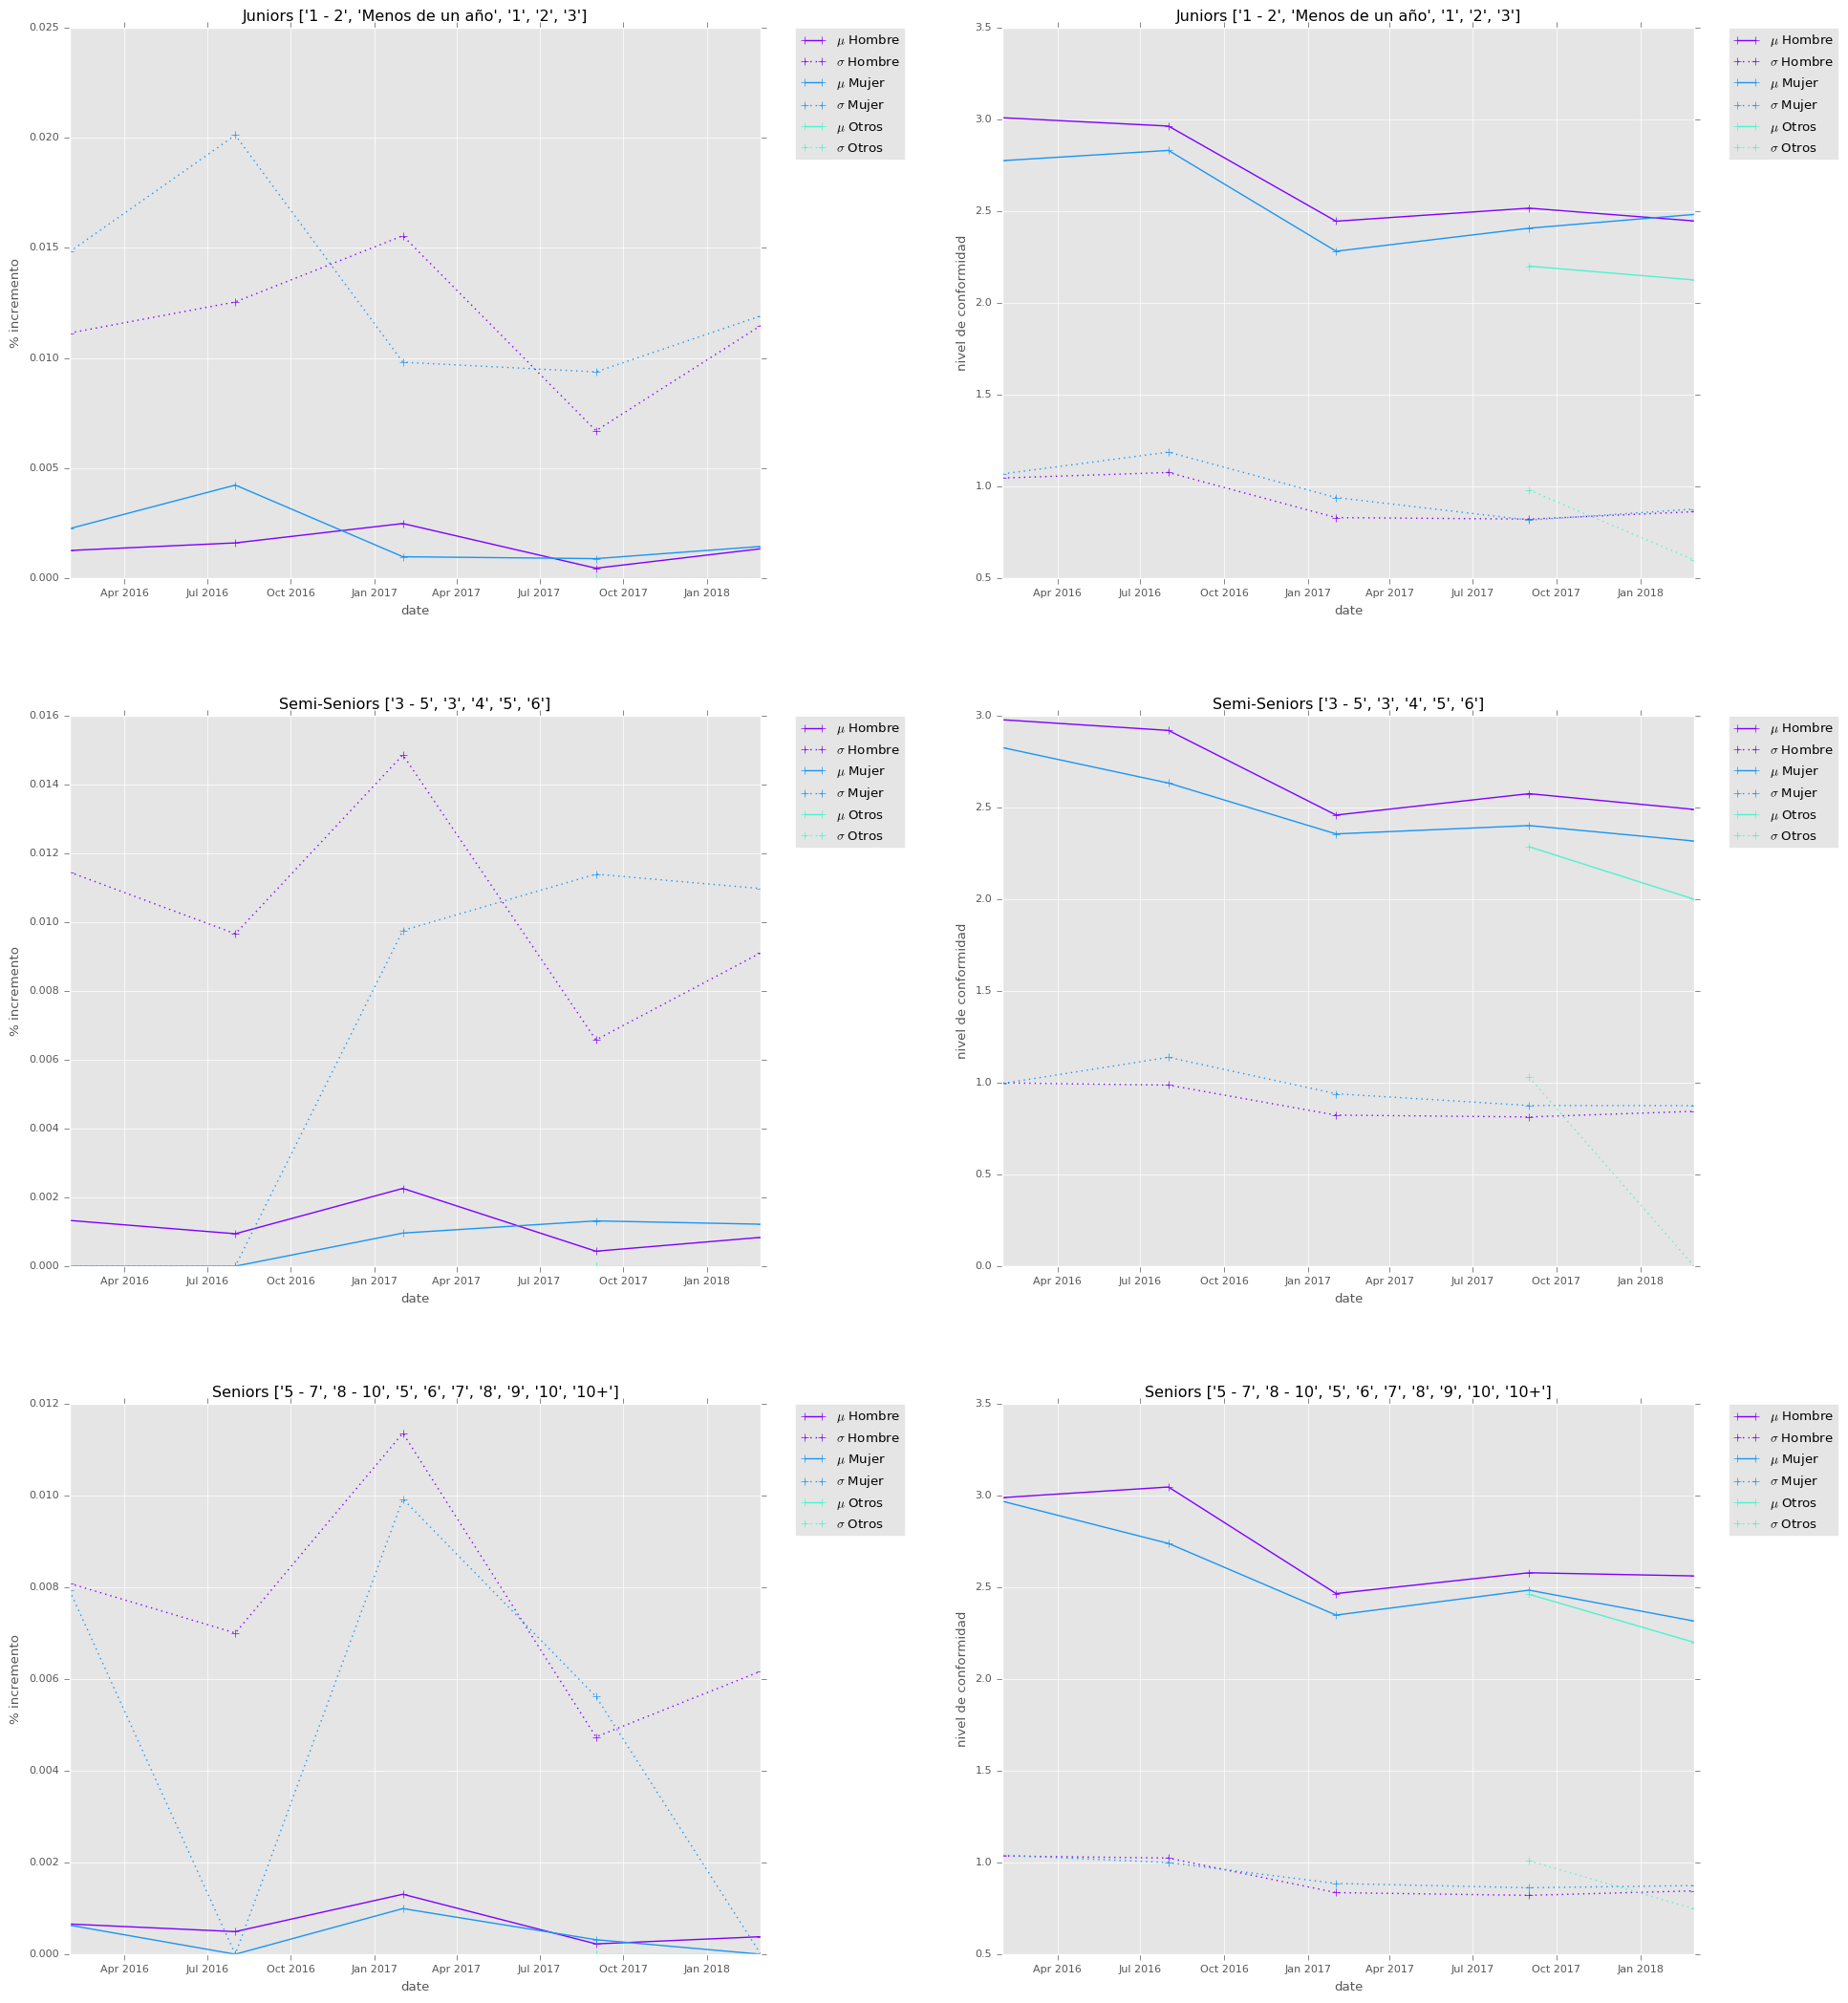

In [5]:
%matplotlib inline

def getPlotIncreaseSeries(currencySeries):
    s = currencySeries.apply(lambda x: float('{0:.2f}'.format(round(x/1000, 1))))
    mu, sigma = np.mean(s), np.std(s)
    median = np.median(s)
    t = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
    d = sigma**2/mu
    return mu, sigma, t, d, median, s

def getPlotHappinessSeries(currencySeries):
    s = currencySeries
    mu, sigma = np.mean(s), np.std(s)
    median = np.median(s)
    t = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
    d = sigma**2/mu
    return mu, sigma, t, d, median, s

plt.rcParams.update({'figure.figsize': (20.0, 24.0), 'font.size': 8})
yoes_colors = cm.rainbow(np.linspace(0, 1, 2*len(yoes_ranges)))

fig, ax = plt.subplots(len(yoes_ranges), 2)
for i, yoe_range in enumerate(yoes_ranges):
    for j, gender in enumerate(genders):
        mus, sigmas, dates = [], [], []
        for period in periods:
            dft = df.query('gender == @gender & period == @period & yoe in @yoe_range')
            if len(dft) == 0: continue
            mu, sigma, t, d, m, s = getPlotIncreaseSeries(dft.increase)
            mus.append(mu)
            sigmas.append(sigma)
            dates.append(np.max(dft['publish_date']))

        ax[i][0].plot(dates, mus, '+', label='$\mu$ %s' % gender, ls='-', c=yoes_colors[j])
        ax[i][0].plot(dates, sigmas, '+', label='$\sigma$ %s' % gender, ls=':', c=yoes_colors[j])
        ax[i][0].set_title('%s %s' % (yoes_ranges_names[i], yoe_range))
        
        mus, sigmas, dates = [], [], []
        for period in periods:
            dft = df.query('gender == @gender & period == @period & yoe in @yoe_range')
            if len(dft) == 0: continue
            mu, sigma, t, d, m, s = getPlotHappinessSeries(dft.happiness)
            mus.append(mu)
            sigmas.append(sigma)
            dates.append(np.max(dft['publish_date']))

        ax[i][1].plot(dates, mus, '+', label='$\mu$ %s' % gender, ls='-', c=yoes_colors[j])
        ax[i][1].plot(dates, sigmas, '+', label='$\sigma$ %s' % gender, ls=':', c=yoes_colors[j])
        ax[i][1].set_title('%s %s' % (yoes_ranges_names[i], yoe_range))

    ax[i][0].set_xlabel('date'); ax[i][0].set_ylabel('% incremento')
    ax[i][0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    ax[i][1].set_xlabel('date'); ax[i][1].set_ylabel('nivel de conformidad')
    ax[i][1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

fig.canvas.draw()

## Educación formal por género de la muestra de 2018.01

### Nivel de estudios

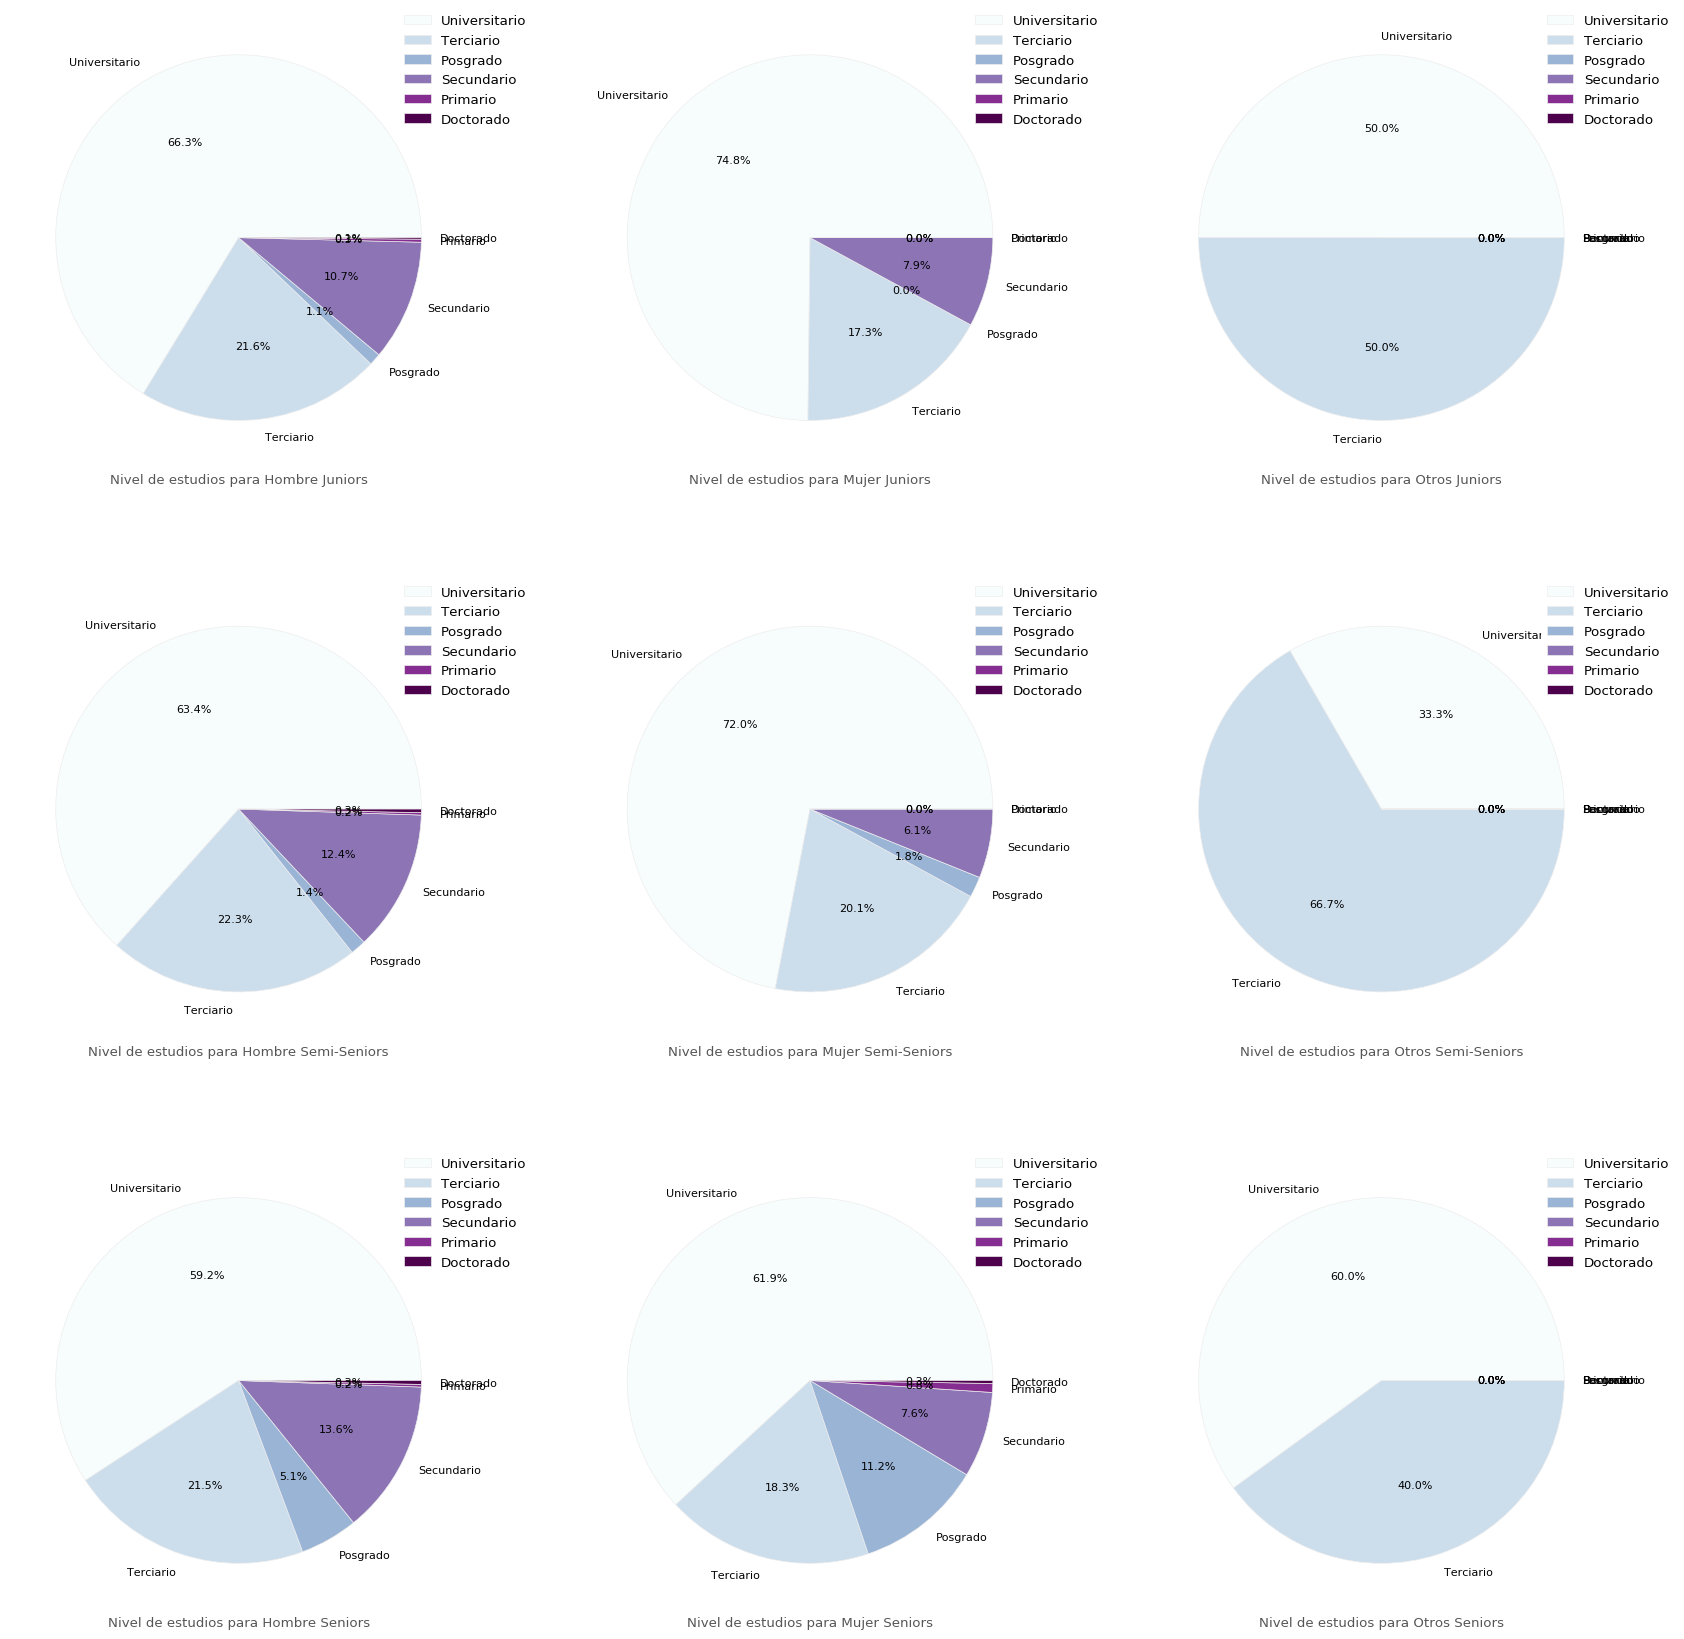

In [6]:
dst_cols = ['salary',
 'location',
 'gender',
 'study',
 'state',
 'age',
 'yoe',
 'yip',
 'role',
 'stack']

dfe = getPeriodDF('2018.01', '2018-03-01', '../../data/2018.01/argentina.csv', 
                  ['Salario mensual (en tu moneda local)', 'Argentina', 'Me identifico', 'Nivel de estudios alcanzado', 'Estado'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute201702])

plt.rcParams.update({'figure.figsize': (20.0, 20.0), 'font.size': 8})

studies = dfe.study.unique()
studies_colors = cm.BuPu(np.linspace(0, 1, len(studies)))

fig, ax = plt.subplots(len(yoes_ranges), len(genders))
for i, yoe_range in enumerate(yoes_ranges):
    for j, gender in enumerate(genders):
        fracs = []
        for study in studies:
            dft = dfe.query('gender == @gender & yoe in @yoe_range & study == @study')
            fracs.append(len(dft))
        ax[i][j].pie(fracs, labels=studies, autopct='%1.1f%%', colors=studies_colors)
        ax[i][j].set_xlabel('Nivel de estudios para %s %s' % (gender, yoes_ranges_names[i]));
        legend = ax[i][j].legend(bbox_to_anchor=(0.85, 1), loc=2, borderaxespad=0.)
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_x(70)
    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.25,
                    wspace=0.25)

fig.canvas.draw()

### Estado de los estudios

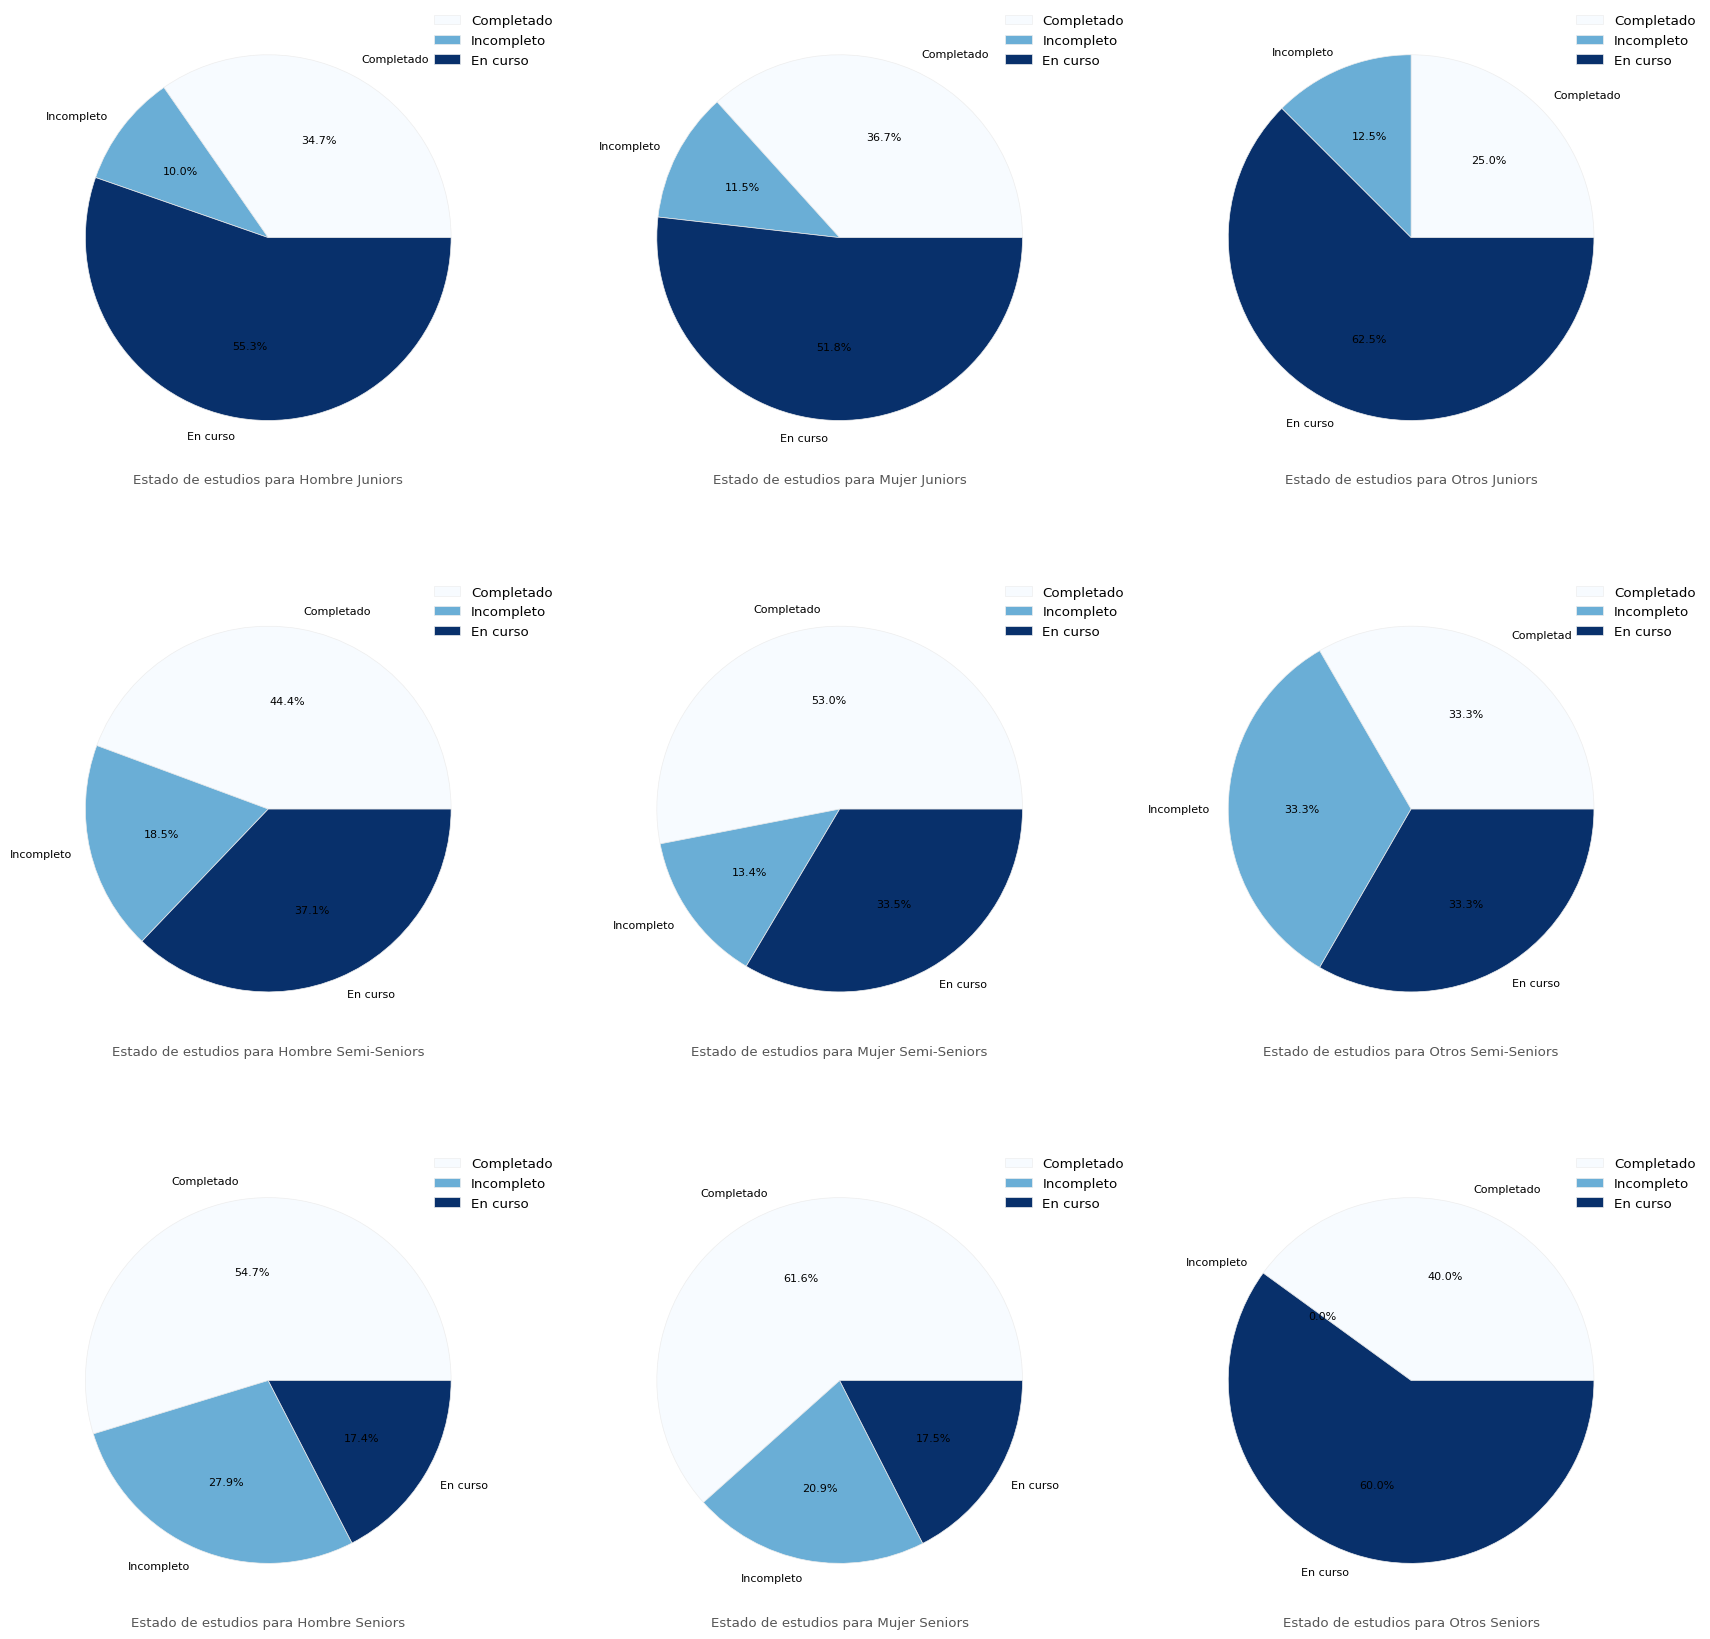

In [7]:
states = dfe.state.unique()
states_colors = cm.Blues(np.linspace(0, 1, len(states)))

plt.rcParams.update({'figure.figsize': (20.0, 20.0), 'font.size': 8})

fig, ax = plt.subplots(len(yoes_ranges), len(genders))
for i, yoe_range in enumerate(yoes_ranges):
    for j, gender in enumerate(genders):
        fracs = []
        for state in states:
            dft = dfe.query('gender == @gender & yoe in @yoe_range & state == @state')
            fracs.append(len(dft))
        ax[i][j].pie(fracs, labels=states, autopct='%1.1f%%', colors=states_colors)
        ax[i][j].set_xlabel('Estado de estudios para %s %s' % (gender, yoes_ranges_names[i]));
        legend = ax[i][j].legend(bbox_to_anchor=(0.85, 1), loc=2, borderaxespad=0.)
        legend.get_frame().set_facecolor('white')
    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.25,
                    wspace=0.25)

fig.canvas.draw()

In [8]:
display(md("""
## Bonus track

Detalle de sueldos por período, seniority, y género.
Véase también [CESSI dio a conocer el salario de los Programadores en Argentina (2017)](http://www.cessi.org.ar/ver-noticias-cessi-dio-a-conocer-el-salario-de-los-programadores-en-argentina-2129)
"""))


dfn = pd.DataFrame(dfnd, columns=['Género', 'Seniority', 'period', 'Salario Bruto mensual', 'Desviación estándar'])
dfn

for i, period in enumerate(reversed(periods)):
    display(md('### %s' % period))
    display(dfn.query('period == @period'))


## Bonus track

Detalle de sueldos por período, seniority, y género.
Véase también [CESSI dio a conocer el salario de los Programadores en Argentina (2017)](http://www.cessi.org.ar/ver-noticias-cessi-dio-a-conocer-el-salario-de-los-programadores-en-argentina-2129)


### 2018.01

,Género,Seniority,period,Salario Bruto mensual,Desviación estándar
4,Hombre,Juniors,2018.01,23.926000,13.393525
9,Mujer,Juniors,2018.01,23.156115,11.120705
11,Otros,Juniors,2018.01,22.237500,8.022615
16,Hombre,Semi-Seniors,2018.01,33.421025,20.108929
21,Mujer,Semi-Seniors,2018.01,29.729268,12.451021
23,Otros,Semi-Seniors,2018.01,28.366667,2.654974
28,Hombre,Seniors,2018.01,47.518953,28.966102
33,Mujer,Seniors,2018.01,37.337337,18.221575
35,Otros,Seniors,2018.01,44.600000,25.491960


### 2017.02

,Género,Seniority,period,Salario Bruto mensual,Desviación estándar
3,Hombre,Juniors,2017.02,22.257480,11.832849
8,Mujer,Juniors,2017.02,20.246903,7.922758
10,Otros,Juniors,2017.02,26.320000,19.660051
15,Hombre,Semi-Seniors,2017.02,30.186012,16.461985
20,Mujer,Semi-Seniors,2017.02,30.402632,15.933381
22,Otros,Semi-Seniors,2017.02,32.485714,21.407571
27,Hombre,Seniors,2017.02,42.138753,25.585862
32,Mujer,Seniors,2017.02,37.127532,17.357438
34,Otros,Seniors,2017.02,46.300000,22.502581


### 2017.01

,Género,Seniority,period,Salario Bruto mensual,Desviación estándar
2,Hombre,Juniors,2017.01,17.773200,8.071967
7,Mujer,Juniors,2017.01,17.087379,8.367328
14,Hombre,Semi-Seniors,2017.01,23.722034,10.861093
19,Mujer,Semi-Seniors,2017.01,22.267308,10.409393
26,Hombre,Seniors,2017.01,31.226782,16.490655
31,Mujer,Seniors,2017.01,27.227861,11.869105


### 2016.02

,Género,Seniority,period,Salario Bruto mensual,Desviación estándar
1,Hombre,Juniors,2016.02,16.047674,16.167943
6,Mujer,Juniors,2016.02,15.288732,10.758312
13,Hombre,Semi-Seniors,2016.02,20.026973,11.060387
18,Mujer,Semi-Seniors,2016.02,19.489873,8.208017
25,Hombre,Seniors,2016.02,27.762592,14.072298
30,Mujer,Seniors,2016.02,27.952239,23.824735


### 2016.01

,Género,Seniority,period,Salario Bruto mensual,Desviación estándar
0,Hombre,Juniors,2016.01,14.183154,15.205461
5,Mujer,Juniors,2016.01,13.808989,10.260655
12,Hombre,Semi-Seniors,2016.01,17.260857,14.086386
17,Mujer,Semi-Seniors,2016.01,15.630435,7.932456
24,Hombre,Seniors,2016.01,22.315252,14.905378
29,Mujer,Seniors,2016.01,20.658861,10.821493
